# Data and sentiment analysis of tweets with the `#metooGR` hashtag

## Install libraries
In this section we install libraries that might be missing from the local environment. The implementation was done in [Google Colab](https://colab.research.google.com/), so here we only install libraries missing from Colab's environment.

In [2]:
!pip install tweepy==4.10.0 # note that we use tweepy 4.10 version to work with v2 twitter API
!pip install unidecode # used to process the data retrieved from the Twitter API
!python -m spacy download el_core_news_md # used to process greek text for sentiment analysis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tweepy
    Found existing installation: tweepy 3.10.0
    Uninstalling tweepy-3.10.0:
      Successfully uninstalled tweepy-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Import libraries
In this section we import the Python libraries that we are going to use for this project.

In [76]:
import tweepy
import requests
import json
import re
import string
import glob
import spacy
import pandas as pd
import numpy as np
import unicodedata as ud
import matplotlib.pyplot as plt

from google.colab import drive
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

## Data collection
In this section we collect the tweets that we will analyse using Twitter's API.

### Using Twitter's search API
Ref. API endpoint: [GET /2/tweets/tweets/search/recent](https://developer.twitter.com/en/docs/twitter-api/tweets/search/api-reference/get-tweets-search-recent)

[Link](https://developer.twitter.com/apitools/api?endpoint=%2F2%2Ftweets%2Fsearch%2Frecent&method=get) to API endpoint explorer to perform sample searches.

After submitting the query we save the results in pandas dataframes and finally store them to excel files. In the subsequent sections of this notebook we load the excel files from Google Drive and perform our analysis and visualizations.

In [72]:
# parameters:
bearer_token = "MYTOKEN"
query = '#metoogr'
maxResults =100
flattenLimit = 100

# define the tweet attributes to retrieve
tweetFields = ['id',
               'created_at',
               'text',
               'public_metrics',
               'referenced_tweets',
               'entities',
               'source']

# define the user attributes to retrieve
userFields = ['id',
              'username',
              'created_at',
              'verified',
              'public_metrics']

# include the user attributes in the 'includes' element of the response
expansionFields=["author_id"]

# instantiate client 
client = tweepy.Client(bearer_token)

# request a paginated result with the query and the attributes defined above
results =  tweepy.Paginator(client.search_recent_tweets,
                            query,
                            max_results = maxResults,
                            tweet_fields = tweetFields,
                            expansions = expansionFields,
                            user_fields = userFields)

In [73]:
# instantiate client 
client = tweepy.Client(bearer_token)

# request a paginated result with the query and the attributes defined above
results =  tweepy.Paginator(client.search_recent_tweets,
                            query,
                            max_results = maxResults,
                            tweet_fields = tweetFields,
                            expansions = expansionFields,
                            user_fields = userFields)

In [85]:
# create an empty dataframe for the tweet attributes included in the response
tweetsDf = pd.DataFrame()

# iterate through the response
for n,page in enumerate(results):  
    for tweet in page.data:
        tempDf = pd.json_normalize(tweet.data, sep="_")
        tweetsDf = tweetsDf.append(tempDf, ignore_index=True)

# create an empty dataframe for the user attributes included in the response
usersDf = pd.DataFrame()

# iterate through the response
for n,page in enumerate(results):  
    for user in page.includes['users']:
        tempDf = pd.json_normalize(user.data, sep="_")
        usersDf = usersDf.append(tempDf, ignore_index=True)

# rename author id column
usersDf = usersDf.rename(columns={"id": "author_id"})

# join data frames on the author_id column
combined = pd.merge(tweetsDf, usersDf, on='author_id',how='left')

# drop duplicate rows based on the tweet id that are produced by the merge operation
combined = combined.drop_duplicates(subset=['id'], keep='first')

# export combined data frame to xls for future reference
combined.to_excel('output.xlsx', sheet_name='combinedTweetsUsers')

# export user and tweets data frames to xls for future reference (we use the previously generated xls file to append additional sheets)
with pd.ExcelWriter('output.xlsx',mode='a') as writer:  
    tweetsDf.to_excel(writer, sheet_name='tweets')
    usersDf.to_excel(writer, sheet_name='users')

In [76]:
# print data frame row counts
print('tweets df:', len(tweetsDf))
print('users df:', len(usersDf))
print('combined df:', len(combined))

tweets df: 1427
users df: 1046
combined df: 1427


### Using Twitter's recent tweets count API endpoint
Ref. API endpoint: [GET /2/tweets/counts/recent](https://developer.twitter.com/en/docs/twitter-api/tweets/counts/api-reference/get-tweets-counts-recent)

The recent Tweet counts endpoint returns count of Tweets from the last seven days that match a query.

**Note:** The API endpoint was called at 02/07/2022, therefore it returns the counts for the last seven days (25/06 - 02/07). If it is called again it will return the tweet counts for the last seven days, so the days and counts will be different. To replicate the result, access to the Enterprise / Academic Research API is required and the `get_recent_tweets_count()` needs to include the respective dates.

In [19]:
tweetCounts = client.get_recent_tweets_count(query=query, granularity='day')

for count in tweetCounts.data:
    print(count)

{'end': '2022-06-26T00:00:00.000Z', 'start': '2022-06-25T15:59:08.000Z', 'tweet_count': 41}
{'end': '2022-06-27T00:00:00.000Z', 'start': '2022-06-26T00:00:00.000Z', 'tweet_count': 55}
{'end': '2022-06-28T00:00:00.000Z', 'start': '2022-06-27T00:00:00.000Z', 'tweet_count': 127}
{'end': '2022-06-29T00:00:00.000Z', 'start': '2022-06-28T00:00:00.000Z', 'tweet_count': 128}
{'end': '2022-06-30T00:00:00.000Z', 'start': '2022-06-29T00:00:00.000Z', 'tweet_count': 228}
{'end': '2022-07-01T00:00:00.000Z', 'start': '2022-06-30T00:00:00.000Z', 'tweet_count': 136}
{'end': '2022-07-02T00:00:00.000Z', 'start': '2022-07-01T00:00:00.000Z', 'tweet_count': 438}
{'end': '2022-07-02T15:59:08.000Z', 'start': '2022-07-02T00:00:00.000Z', 'tweet_count': 202}


In [20]:
# create pandas dataframe with results
df = pd.DataFrame(tweetCounts.data)

# create a date column from the "start" datetime column
df['date'] = pd.to_datetime(df['start']).dt.date

# save the data frame to csv for future reference
df.to_csv('metooTweetCount.csv',index=False)  

### Functions
In this section we list the functions that we developed to connect to the Twitter API, capture the tweets and perform basic cleaning tasks on the tweet text and metadata.

In [ ]:
class StreamListener(tweepy.StreamListener):

    def on_connect(self):
    # initialize connection to Twitter API with Tweepy
        print("Initialized connection to the Twitter streaming API.")

    def on_error(self, status_code):
    # print the error returned by Tweepy if something's gone wrong
        print('Error: ' + repr(status_code),
                file=sys.stderr)
        return False
    
    def on_limit(self,status):
    # sleep for 15 minutes in case we track a hashtag with a very large volume of tweets which would cause the API rate limit to be reached
        print("API rate limit exceeded, pausing for 15 minutes")
        time.sleep(15 * 60)
        return True

    def check_reply(status):
    # Return True if tweet is a reply to another tweet
        if hasattr(status, "in_reply_to_status_id"):
            return True
        return False

    def check_retweeted(status):
    # Return true if tweet in stream contains a retweeted tweet
        if hasattr(status, "retweeted_status"):
            retweet = status.retweeted_status
            if hasattr(retweet, 'user'):
                if retweet.user is not None:
                    if hasattr(retweet.user, "screen_name"):
                        if retweet.user.screen_name is not None:
                            return True
        return False

    def check_quoted_tweet(status):
    # Return true if tweet in stream contains a quoted tweet
        if hasattr(status, "quoted_status"):
            quote_tweet = status.quoted_status
            if hasattr(status.quoted_status, 'user'):
                if status.quoted_status.user is not None:
                    user = status.quoted_status.user
                    if hasattr(user, 'screen_name'):
                        if user.screen_name is not None:
                            return True
        return False

    def on_status(self, status):
    # This is the main function to capture the tweet's attributes from the stream
        print('incoming id:',status.id_str,"from user:",status.user.screen_name,"with text:",status.text)

        # this is the structure where we store the tweet attributes
        tweetEntity = []
        tweetDetails = {}
        
        # Capture tweeting user's profile attributes
        tweetDetails['userId'] = status.user.id_str
        tweetDetails['userName'] = status.user.name
        tweetDetails['userScreenName'] = status.user.screen_name
        tweetDetails['userLocation'] = status.user.location
        tweetDetails['userCreationDate'] = status.user.created_at.strftime("%d-%b-%Y")
        tweetDetails['userFollowers'] = status.user.followers_count
        tweetDetails['userFollowings'] = status.user.friends_count
        tweetDetails['userListedCount'] = status.user.listed_count
        tweetDetails['userIsVerified'] = status.user.verified
        tweetDetails['userStatusesCount'] = status.user.statuses_count
        tweetDetails['userFavoritesCount'] = status.user.favourites_count
        tweetDetails['tweetCoordinates'] = status.coordinates
        tweetDetails['tweetLanguage'] = status.lang
        tweetDetails['tweetId'] = status.id_str
        tweetDetails['tweetCreationDate'] = status.created_at.strftime("%d-%b-%Y")

        # Capture tweet attributes. If the tweet being streamed is a quote, we only capture the top-level tweet's attributes.
        attributes = ['hashtags','user_mentions','urls','symbols','media']
        entity_dict = {}
        for attr in attributes:
                #entity = None remove after test passes
                entity = 'unprocessed'
                entity_count = attr+"_count"
                #while entity is None: remove after test passes
                while entity is 'unprocessed':
                    try:
                        entity = status.extended_tweet['extended_entities'][attr]
                        break
                    except (AttributeError, KeyError) as e:
                        pass
                    try:
                        entity = status.extended_tweet['entities'][attr]
                        break
                    except (AttributeError, KeyError) as e:
                        pass
                    try:
                        entity = status.extended_entities[attr]
                        break
                    except (AttributeError, KeyError) as e:
                        pass
                    try:
                        entity = status.entities[attr]
                        break
                    except (AttributeError, KeyError) as e:
                        break

                #if entity: # remove after test passes
                if entity != 'unprocessed':
                    if len(entity) == 0:
                        tweetDetails[attr] = None
                    else:
                        tweetDetails[attr] = entity                    
                    tweetDetails[entity_count] = len(entity)
                    entity_dict[attr] = entity
                else:
                    tweetDetails[attr] = None
                    tweetDetails[entity_count] = 0
                    entity = None

                if attr == 'media' and entity != 'null' and entity is not None:
                        media_container = []
                        for index, med in enumerate(entity):
                            media_details = {}
                            media_details['id_Str'] = entity[index]['id_str']
                            media_details['type'] = entity[index]['type']
                            media_details['media_url'] = entity[index]['media_url_https']
                            media_container.append(media_details)
                        tweetDetails['media_info'] = media_container

        # get the tweet text
        if hasattr(status, "extended_tweet"):
            try:
                tweetDetails['full_text'] = status.extended_tweet['full_text']
            except:
                tweetDetails['full_text'] = status.text         
        else:
            tweetDetails['full_text'] = status.text

        # Check if tweet is a reply to another tweet and if yes capture tweet's id, user's id, user's screen name.
        if StreamListener.check_reply(status):
            tweetDetails['is_reply'] = True
            tweetDetails['tweet_reply_id_str'] = status.in_reply_to_status_id
            tweetDetails['tweet_reply_user_id_str'] = status.in_reply_to_user_id_str
            tweetDetails['tweet_reply_user_screen_name'] = status.in_reply_to_screen_name
        else:
            tweetDetails['is_reply'] = False

        # Check if tweet contains a retweet and get the retweeted tweet's id, user id and user screen name. Get also full text.
        if StreamListener.check_retweeted(status):
            tweetDetails['has_retweet'] = True
            tweetDetails['retweeted_tweet_id'] = status.retweeted_status.id_str
            tweetDetails['retweeted_tweet_user_id'] = status.retweeted_status.user.id_str
            tweetDetails['retweeted_tweet_user_screen_name'] = status.retweeted_status.user.screen_name
        else:
            tweetDetails['has_retweet'] = False

        # Check if tweet contains a quote and get the quoted tweet's id, user id and user screen name
        if StreamListener.check_quoted_tweet(status):
            tweetDetails['has_quote'] = True
            tweetDetails['quoted_tweet_id'] =  status.quoted_status.id_str
            tweetDetails['quoted_tweet_user_id'] =  status.quoted_status.user.id_str
            tweetDetails['quoted_tweet_user_screen_name'] =  status.quoted_status.user.screen_name
        else:
            tweetDetails['has_quote'] = False

        # finally append the captured attributes to the tweet entity container 
        tweetEntity.append(tweetDetails)
        
        # clean media details
        if 'media' in tweetDetails: del tweetDetails['media'] 
        
        # save to json
        output = json.dumps(tweetEntity, ensure_ascii=False)
        print("saving original tweet structure to json")
        with open('data-input.json', 'a') as outfile:
            outfile.write(output)
            outfile.write("\n")
        print("saved!")        
        print("saving processed tweet output to json")
        with open('data-output.json', 'a') as outfile:
            outfile.write(output)
            outfile.write("\n")
        print('Successfully processed',tweetDetails['tweetId'],"printing output json")
        print(output)
        print("waiting for next tweet in stream")

## Load dataset
In this section we load the datasets which contain the tweets we extracted from the Twitter API into pandas data frames.

In [2]:
# retrieve csv from Google Drive
# import dataset
drive.mount('/content/drive', force_remount=True)

# create pandas dataframe with dataset containing daily tweet counts for the week 25/06 - 02/07
dfTweetCount = pd.read_csv('/content/drive/My Drive/Datasets/metooTweetCount.csv')

# create pandas daataframes with the datasets:
# combined tweets - users
dfCombined = pd.read_excel('/content/drive/My Drive/Datasets/output.xlsx', sheet_name = 'combinedTweetsUsers')
# tweets
dfTweets = pd.read_excel('/content/drive/My Drive/Datasets/output.xlsx', sheet_name = 'tweets')
# users
dfUsers = pd.read_excel('/content/drive/My Drive/Datasets/output.xlsx', sheet_name = 'users')

Mounted at /content/drive


## Exploratory Data Analysis (EDA)
In this section we present visualizations on the users and the tweets included in the dataset.

### What is the daily volume of recent tweets for the `#metoogr` hashtag?


In [48]:
# the diagram was created in datawrapper.de using the "dfTweetCoun"t data frame as input
%%html
<iframe title="#metooGR tweet count" aria-label="Column Chart" id="datawrapper-chart-laGe2" src="https://datawrapper.dwcdn.net/laGe2/2/" scrolling="no" frameborder="0" style="border: none;" width="800" height="600"></iframe>

### How many tweets were posted on an hourly basis with the `#metooGR` hashtag?

In [121]:
# keep only the 'id' and 'created_at' columns
dfTweetsPerHour = dfTweets[['id', 'created_at']]

# convert 'created_at' to datetime
dfTweetsPerHour['created_at']=pd.to_datetime(dfTweetsPerHour['created_at'])

# extract the hour from the tweet creation date
dfTweetsPerHour['hour'] = dfTweetsPerHour['created_at'].dt.hour

# group by hour and count tweets
dfTweetsPerHour = dfTweetsPerHour.groupby(['hour'])['id'].count().sort_values(ascending=False).reset_index(name='tweetCount')

# save to xls
dfTweetsPerHour.to_excel('dfTweetsPerHour.xlsx')

dfTweetsPerHour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


hour  tweetCount
0     17         126
1     16         113
2     18         105
3     15         102
4      9         101
5     11          93
6     12          87
7     19          79
8     13          71
9     14          71
10     7          68
11    10          66
12     8          62
13    21          62
14    20          61
15     5          48
16     6          36
17    22          23
18     4          16
19     0          11
20    23          11
21     1           9
22     2           9
23     3           5

In [24]:
# the diagram was created in datawrapper.de using the previous data frame as input
%%html
<iframe title="When are the users tweeting about #metooGR?" aria-label="Interactive line chart" id="datawrapper-chart-q4iWY" src="https://datawrapper.dwcdn.net/q4iWY/1/" scrolling="no" frameborder="0" style="border: none;" width="728" height="739"></iframe>

### How many tweets have the dataset's users posted?

In [10]:
# load previously exported xls from Google Drive location
drive.mount('/content/drive', force_remount=True)

# create pandas dataframe with dataset
df = pd.read_excel('/content/drive/My Drive/Datasets/output.xlsx', sheet_name = 'users')

Mounted at /content/drive


In [30]:
# generate tweet frequency table (each user in the dataset corresponds to one tweet)
frequencyTweets = df.groupby(['author_id'])['author_id'].count().sort_values(ascending=False).reset_index(name='tweetCount')
interval_range = pd.interval_range(start=0, freq=3, end=12)
frequencyTweets = pd.cut(frequencyTweets['tweetCount'], bins=interval_range).value_counts()

# save to xls
frequencyTweets.to_excel('frequencyTweets.xlsx')

In [31]:
# the diagram was created in datawrapper.de using the previous data frame as input
%%html
<iframe title="Number of tweets posted by the dataset's users" aria-label="Column Chart" id="datawrapper-chart-z53k3" src="https://datawrapper.dwcdn.net/z53k3/1/" scrolling="no" frameborder="0" style="border: none;" width="761" height="478"></iframe>

### How 'old' are the user accounts posting in `#metooGR`?

In [5]:
# remove duplicate users (the dataset contains multiple tweets by several users, therefore we keep each user only once)
users = dfUsers.drop_duplicates(subset=['author_id'], keep='first')

In [16]:
# keep only the 'author_id' and 'created_at' columns
userAge = users[['author_id', 'created_at']]

# convert 'created_at' to datetime
userAge['created_at']=pd.to_datetime(userAge['created_at'])

# extract the year from the user account creation date
userAge['year'] = userAge['created_at'].dt.year

# drop the "created_at" column
userAge = userAge[['author_id', 'year']]

# group by year and count users
userAge = userAge.groupby(['year'])['author_id'].count().sort_values(ascending=False).reset_index(name='userCount')
userAge

# save to csv to import it into datawrapper
userAge.to_csv('userAge.csv',index=False)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
# the diagram was created in datawrapper.de using the previous data frame as input
%%html
<iframe title="In which year did the users create their Twitter account?" aria-label="Column Chart" id="datawrapper-chart-m9DPs" src="https://datawrapper.dwcdn.net/m9DPs/1/" scrolling="no" frameborder="0" style="border: none;" width="867" height="459"></iframe>

### Which apps are used to post tweets with the `#metooGR` hashtag?

In [29]:
# keep only the 'id' and 'source' columns
tweetSources = dfTweets[['id', 'source']]

# group by source and count tweets
tweetSources = tweetSources.groupby(['source'])['id'].count().sort_values(ascending=False).reset_index(name='tweetCount')
tweetSources

# save to csv to import it into datawrapper
tweetSources.to_csv('tweetSources.csv',index=False)  

In [30]:
# the diagram was created in datawrapper.de using the previous data frame as input
%%html
<iframe title="Which apps are used to post tweets with the #metooGR hashtag?" aria-label="Donut Chart" id="datawrapper-chart-MtTwU" src="https://datawrapper.dwcdn.net/MtTwU/1/" scrolling="no" frameborder="0" style="border: none;" width="710" height="471"></iframe>

### Which users have posted the most tweets with the `#metooGR` hashtag?

In [45]:
# keep only the 'id', 'author_id', the 'public_metrics_', 'name', 'username'  and 'source' columns
topUsers = dfCombined[['id', 'author_id','public_metrics_followers_count','public_metrics_following_count','public_metrics_tweet_count','public_metrics_listed_count','name','username']]

# group by user and tweet count
topUsers = topUsers.groupby(['author_id','public_metrics_followers_count','public_metrics_following_count','public_metrics_tweet_count','public_metrics_listed_count','name','username'])['id'].count().sort_values(ascending=False).reset_index(name='tweetCount')

# keep top 20 users by tweet count
topUsers = topUsers.nlargest(20, 'tweetCount')

# save to csv to import it into datawrapper
topUsers.to_excel('topUsers.xlsx',index=False)  

In [46]:
# the diagram was created in datawrapper.de using the previous data frame as input
%%html
<iframe title="Which users have posted the most tweets with the #metooGR hashtag?" aria-label="Table" id="datawrapper-chart-lDqpA" src="https://datawrapper.dwcdn.net/lDqpA/1/" scrolling="no" frameborder="0" style="border: none;" width="961" height="579"></iframe>

### Which are the most popular hashtags?

In [72]:
# keep only the 'id' and 'entities_hashtags' columns
hashtags = dfCombined[['id', 'entities_hashtags']]

# remove rows with NaN
hashtags=hashtags.dropna(subset=['entities_hashtags'])

# create list with hashtags
mylist = hashtags['entities_hashtags'].tolist()

# create empty dictionary
hashtagCounts = {}

# loop over dictionaries nested in lists and count the tag key values
for i,j in enumerate(mylist):
    j = j.replace("'", '"')
    j = json.loads(j)
    for k,v in enumerate(j):
        for k,v in v.items():
            if k == 'tag':
                v = v.lower()
                d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
                v = ud.normalize('NFD',v).translate(d)
                if v in hashtagCounts:
                    hashtagCounts[v] += 1
                else:
                    hashtagCounts[v] = 1

# convert dict to pandas data frame
hashtagsDf = pd.DataFrame.from_dict(hashtagCounts,orient='index',columns=['count'])
hashtagsDf = hashtagsDf.rename_axis('hashtag').reset_index()

# keep top 20 hashtags
tophashtags = hashtagsDf.nlargest(20, 'count')

# save to csv to import it into datawrapper
tophashtags.to_csv('tophashtags.csv',index=False)  

In [73]:
# the diagram was created in datawrapper.de using the previous data frame as input
%%html
<iframe title="20 most popular hashtags in the dataset" aria-label="Dot Plot" id="datawrapper-chart-S8ag3" src="https://datawrapper.dwcdn.net/S8ag3/1/" scrolling="no" frameborder="0" style="border: none;" width="600" height="452"></iframe>

### Which are the tweets most retweeted?


In [ ]:
# remove rows with NaN (not containing a retweet)
retweetedTweets = dfCombined.dropna(subset=['referenced_tweets'])

# keep only 'retweeted' keys in referenced_tweets column
retweetedTweets = retweetedTweets[retweetedTweets['referenced_tweets'].str.contains("retweeted")]

In [104]:
# create list with retweeted tweet ids
mylist = retweetedTweets['referenced_tweets'].tolist()

# create empty dictionary
retweetCounts = {}

# loop over dictionaries nested in lists and count the tag key values
for i,j in enumerate(mylist):
    j = j.replace("'", '"')
    j = json.loads(j)
    for k,v in enumerate(j):
        for k,v in v.items():
            if k == 'id':
                if v in retweetCounts:
                    retweetCounts[v] += 1
                else:
                    retweetCounts[v] = 1

# convert dict to pandas data frame
retweetsDf = pd.DataFrame.from_dict(retweetCounts,orient='index',columns=['count'])
retweetsDf = retweetsDf.rename_axis('id').reset_index().sort_values(by=['count'], ascending=False)

# convert id to integer
retweetsDf["id"] = retweetsDf["id"].astype(int)

# keep only the 'id' and 'entities_hashtags' columns
temp = dfCombined[['id', 'username','text']]

# join data frames on the id column
topRetweetedTweets = pd.merge(retweetsDf, temp, on='id',how='left')

# keep top 20 hashtags
topRetweetedTweets = topRetweetedTweets.nlargest(20, 'count')

# save to csv to import it into datawrapper
topRetweetedTweets.to_csv('topRetweetedTweets.csv',index=False)  

In [105]:
# the diagram was created in datawrapper.de using the previous data frame as input
%%html
<iframe title="Most retweeted tweets" aria-label="Table" id="datawrapper-chart-uBs1C" src="https://datawrapper.dwcdn.net/uBs1C/1/" scrolling="no" frameborder="0" style="border: none;" width="961" height="868"></iframe>

### Word cloud
Let's generate a word cloud to visualise words in the tweets.

In [88]:
# create dataframe containing only with tweet texts and publication dates
tweets = dfCombined[['id','created_at_x','text']]

# load spacy greek pipeline
nlp = spacy.load("el_core_news_md")

# add some stopwords
nlp.Defaults.stop_words |= {'rt','metoo','metoogr','metoocy'}

# remove urls
def removeUrl(text):
    text = re.sub(r'\s*https?://\S+(\s+|$)', ' ', text, flags=re.MULTILINE)
    return text

def removePunctuation(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def removeUsername(text):
    text = re.sub('@[\w]+','',text)
    return text

# remove usernames
tweets['text'] = tweets['text'].apply(lambda x: removeUsername(x))

# remove urls in the tweet body
tweets['text'] = tweets['text'].apply(lambda x: removeUrl(x))

# remove punctuation
tweets['text'] = tweets['text'].apply(lambda x: removePunctuation(x))

# convert to lowercase
tweets['text'] = tweets['text'].str.lower()

# concatenate tweets
text = tweets['text'].str.cat(sep = ' ')

# parse with spacy
corpus = nlp(text)

# tokenize
corpus = ' '.join(token.lemma_ for token in corpus)

'rt   όταν βλέπω ένας άνθρωπος να ξημερωβραδιαζεται σε φρουτάκι τζόγο κτλ δεν είμαι ο άντρας ο ζωή μου ουτε θα εγώ σώσω … ηπα – σε ο φως ο δημοσιότητα ο τρομακτικός καταγγελία καλλιτεχνός για ο αυστηρός δίαιτα metoogr metoo rt   όταν βλέπω ένας άνθρωπος να ξημερωβραδιαζεται σε φρουτάκι τζόγο κτλ δεν είμαι ο άντρας ο ζωή μου ουτε θα εγώ σώσω … rt   ο χατζηπαναγιώτη που έχω ρίξει σφαλιάρα σε ο μανέ δεν πιάνω ως κακοποιητής τι λίγο έχω ο σφαλιάρα μου δηλαδ … rt   όταν βλέπω ένας άνθρωπος να ξημερωβραδιαζεται σε φρουτάκι τζόγο κτλ δεν είμαι ο άντρας ο ζωή μου ουτε θα εγώ σώσω … rt   ο γυναίκα ο αδαμαντίδη είμαι μάλλον φασίστρια και άρα της ασκούσε δικαιολογημένος βία \n\n metoogr συριζαξεφτιλες συ … rt   όταν βλέπω ένας άνθρωπος να ξημερωβραδιαζεται σε φρουτάκι τζόγο κτλ δεν είμαι ο άντρας ο ζωή μου ουτε θα εγώ σώσω … rt   ο φιλιππίδης αποφυλακίστηκε δεν αθωωθηκε \n metoogr φιλιππιδης kalytera rt   αποφυλακίζεται ο φιλιππιδης με περιοριστικός όρος και απαγόρευση εξόδου μου από ο χώρα \n ο 

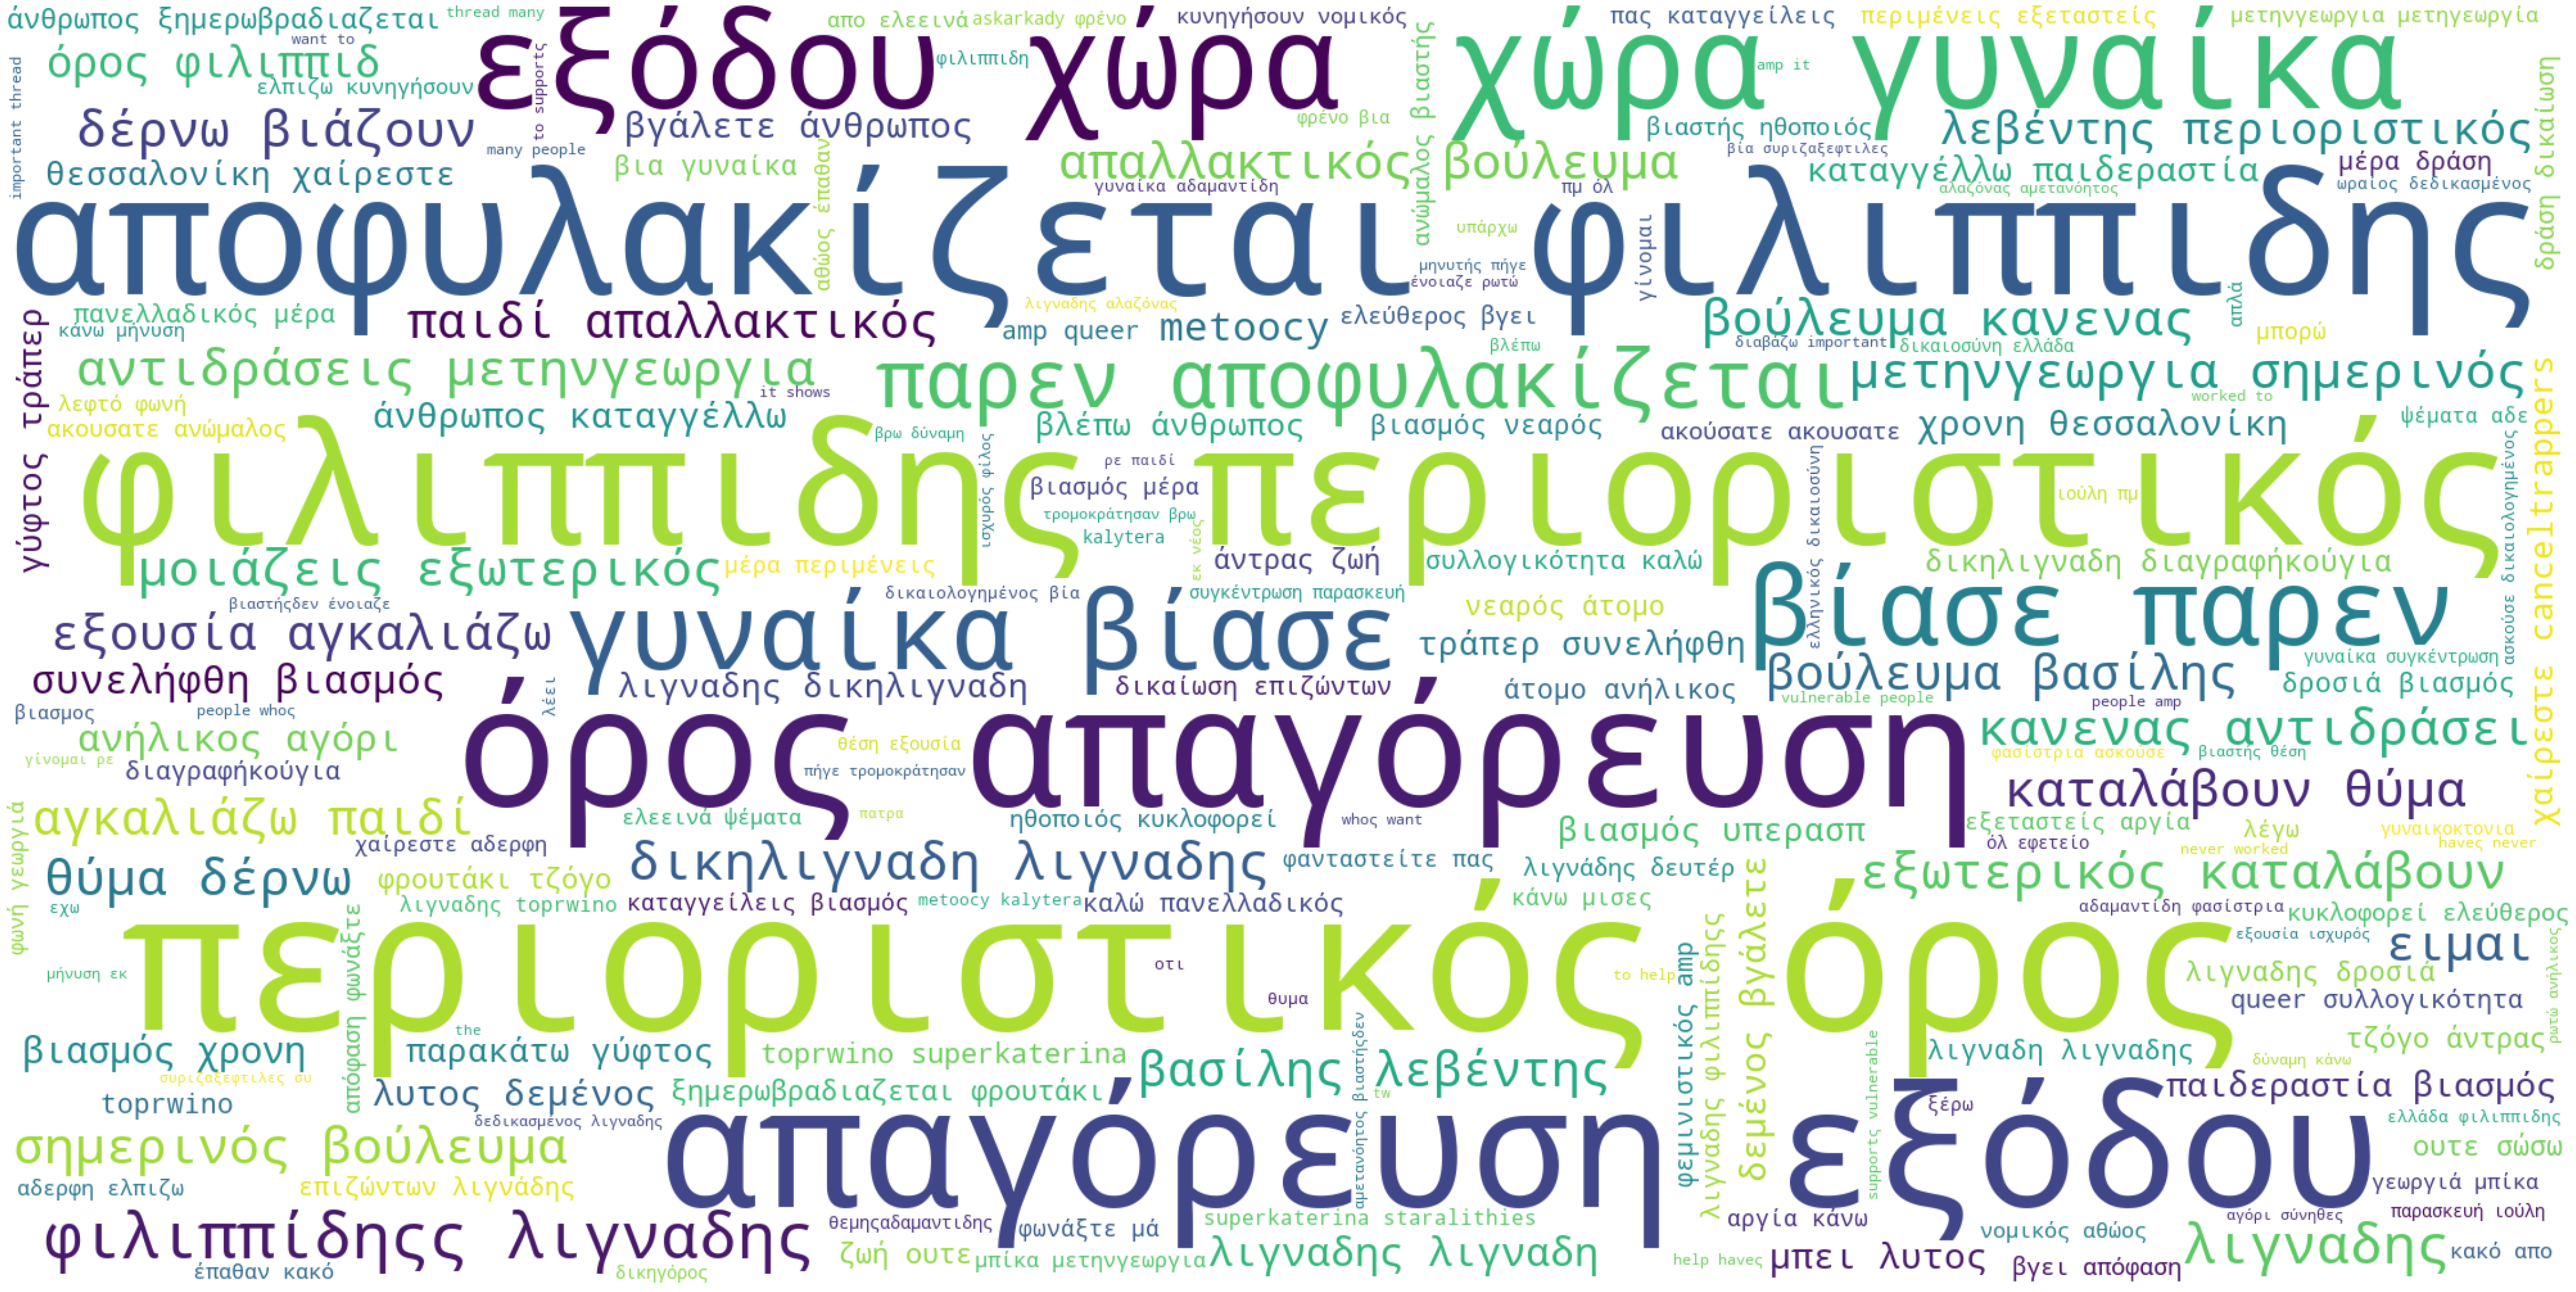

In [47]:
# generate the word cloud
wc = WordCloud(
    stopwords = nlp.Defaults.stop_words,
    width = 2000,
    height = 1000,
    background_color = 'white' ).generate(corpus)

fig = plt.figure(figsize = (60, 40))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Most frequent unigrams

In [68]:
# initialise CountVectorizer object
cv = CountVectorizer(stop_words= nlp.Defaults.stop_words, min_df=0.01, max_df=0.95)

# fit vectorized on tweets column
countVectorizer = cv.fit_transform(tweets['text'])

# create dataframe with the cv result
result = pd.DataFrame(countVectorizer.toarray(), columns=cv.get_feature_names()) 

# create top words list
frequentUnigrams =  result.sum(axis =0)
frequentUnigrams.sort_values(ascending = False).head(10)

# convert series to dataframe
frequentUnigrams = frequentUnigrams.rename_axis('word').reset_index().sort_values(by=[0], ascending=False)

# save to csv to import it into datawrapper
frequentUnigrams.to_excel('frequentUnigrams.xlsx',index=False)  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [69]:
# the diagram was created in datawrapper.de using the previous data frame as input
%%html
<iframe title="20 most frequent words in the tweets" aria-label="Dot Plot" id="datawrapper-chart-2H5IT" src="https://datawrapper.dwcdn.net/2H5IT/1/" scrolling="no" frameborder="0" style="border: none;" width="710" height="433"></iframe>

### 10 most frequent bigrams

In [ ]:
# initialise CountVectorizer object
cv = CountVectorizer(stop_words= nlp.Defaults.stop_words, ngram_range=(2, 2), max_features=10)

# fit vectorized on tweets column
countVectorizer = cv.fit_transform(tweets['text'])

# create dataframe with the cv result
result = pd.DataFrame(countVectorizer.toarray(), columns=cv.get_feature_names()) 

# create top words list
frequentBigrams =  result.sum(axis =0)
frequentBigrams.sort_values(ascending = False).head(10)

# convert series to dataframe
frequentBigrams = frequentBigrams.rename_axis('word').reset_index().sort_values(by=[0], ascending=False)

# save to csv to import it into datawrapper
frequentBigrams.to_excel('frequentΒigrams.xlsx',index=False)  

In [75]:
# the diagram was created in datawrapper.de using the previous data frame as input
%%html
<iframe title="Most frequent bigrams" aria-label="Dot Plot" id="datawrapper-chart-g28xF" src="https://datawrapper.dwcdn.net/g28xF/1/" scrolling="no" frameborder="0" style="border: none;" width="600" height="268"></iframe>

## Sentiment analysis

In [77]:
# get NRC_GREEK_Translated_6_2020.csv into a pandas data frame
filepath = "https://raw.githubusercontent.com/datajour-gr/Data_journalism/master/week10/NRC_GREEK_Translated_6_2020.csv"
emolex_df = pd.read_csv(filepath)
emolex_df.head(5)

word  Positive  Negative  Anger  Anticipation  Disgust  Fear  \
0            αφεση       1.0       0.0    0.0           0.0      0.0   0.0   
1  ενορκη βεβαιωση       0.0       0.0    0.0           0.0      0.0   0.0   
2          εχοντας       0.0       0.0    0.0           0.0      0.0   0.0   
3              εχω       0.0       0.0    0.0           0.0      0.0   0.0   
4             οριο       0.0       0.0    0.0           0.0      0.0   0.0   

   Joy  Sadness  Surprise  Trust  
0  0.0      0.0       0.0    0.0  
1  0.0      0.0       0.0    0.0  
2  0.0      0.0       0.0    0.0  
3  0.0      0.0       0.0    0.0  
4  0.0      0.0       0.0    0.0

In [78]:
# remove duplicates from emolex
emolex_df = emolex_df.drop_duplicates(subset=['word'])
emolex_df = emolex_df.dropna()
emolex_df.reset_index(inplace = True)

vec = CountVectorizer(analyzer = 'word', vocabulary = emolex_df.word, 
                      strip_accents = 'unicode',  
                      stop_words= nlp.Defaults.stop_words,
                      ngram_range=(1, 2))

matrix = vec.fit_transform(tweets['text'])
vocab = vec.get_feature_names()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)

# crete lists with words for different sentiments
angry_words = emolex_df[emolex_df.Anger == 1]['word']
positive_words = emolex_df[emolex_df.Positive == 1]['word']
sadness_words = emolex_df[emolex_df.Sadness == 1]['word']
surprise_words = emolex_df[emolex_df.Surprise == 1]['word']
disgust_words = emolex_df[emolex_df.Disgust == 1]['word']
anticipation_words = emolex_df[emolex_df.Anticipation == 1]['word']
negative_words = emolex_df[emolex_df.Negative == 1]['word']
joy_words = emolex_df[emolex_df.Joy == 1]['word']
trust_words = emolex_df[emolex_df.Trust == 1]['word']
fear_words = emolex_df[emolex_df.Fear == 1]['word']

# append to tweets data frame
tweets['anger'] = wordcount_df[angry_words].sum(axis=1)
tweets['positivity'] = wordcount_df[positive_words].sum(axis=1)
tweets['joy'] = wordcount_df[joy_words].sum(axis=1)
tweets['disgust'] = wordcount_df[disgust_words].sum(axis=1)
tweets['surprise'] = wordcount_df[surprise_words].sum(axis=1)
tweets['trust'] = wordcount_df[trust_words].sum(axis=1)
tweets['anticipation'] = wordcount_df[anticipation_words].sum(axis=1)
tweets['sadness'] = wordcount_df[sadness_words].sum(axis=1)
tweets['negative'] = wordcount_df[negative_words].sum(axis=1)
tweets['fear'] = wordcount_df[fear_words].sum(axis=1)

In [82]:
# print a sample of the result
tweets.head(5)

id              created_at_x  \
0  1543594349031825408  2022-07-03T13:55:46.000Z   
1  1543594285286793217  2022-07-03T13:55:30.000Z   

                                                text  anger  positivity  joy  \
0  rt  όταν βλέπετε έναν άνθρωπο να ξημερωβραδιαζ...      0           0    0   
1  ηπα – στο φως της δημοσιότητας οι τρομακτικές ...      0           0    0   

   disgust  surprise  trust  anticipation  sadness  negative  fear  
0        0         0      0             0        0         0     0  
1        0         0      0             0        0         0     0

In [101]:
# summarise
sentimentSummary = tweets[['anger','positivity','joy','surprise','trust','anticipation','sadness','negative','fear']].sum().rename_axis('sentiment').sort_values(ascending= False)

# save to csv to import it into datawrapper
sentimentSummary.to_excel('sentimentSummary.xlsx')  

In [102]:
# the diagram was created in datawrapper.de using the previous data frame as input
%%html
<iframe title="Sentiment in tweets with the #metooGR hashtag" aria-label="Bar Chart" id="datawrapper-chart-ru5N0" src="https://datawrapper.dwcdn.net/ru5N0/1/" scrolling="no" frameborder="0" style="border: none;" width="848" height="281"></iframe>

In [116]:
# convert 'created_at' to datetime
tweets['created_at_x']=pd.to_datetime(tweets['created_at_x'])

# extract the date from the tweet creation datetime column
tweets['date'] = tweets['created_at_x'].dt.date

# group by date and count tweets
dailySentiment = tweets.groupby(['date'])[['anger','positivity','joy','surprise','trust','anticipation','sadness','negative','fear']].sum().reset_index()

# save to csv to import it into datawrapper
dailySentiment.to_excel('dailySentiment.xlsx')  

In [117]:
# the diagram was created in datawrapper.de using the previous data frame as input
%%html
<iframe title="Daily evolution of sentiments" aria-label="Interactive area chart" id="datawrapper-chart-ZcFfR" src="https://datawrapper.dwcdn.net/ZcFfR/1/" scrolling="no" frameborder="0" style="border: none;" width="658" height="486"></iframe>

In [ ]:
# the diagram was created in datawrapper.de using the previous data frame as input
%%html
<iframe title="Daily evolution of tweets with negative and positive sentiment" aria-label="Interactive line chart" id="datawrapper-chart-K1ZMm" src="https://datawrapper.dwcdn.net/K1ZMm/1/" scrolling="no" frameborder="0" style="border: none;" width="600" height="400"></iframe>